In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [20]:
from generate_video import *

In [11]:
dset = gather_videos(SEQ_LEN=4, still=False, speedup=4, shuffle=False)

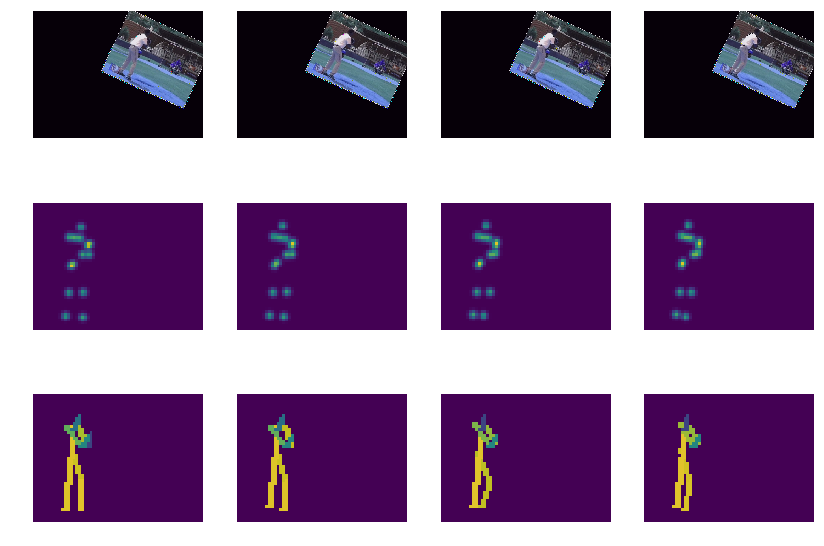

In [33]:
import matplotlib.pyplot as plt

for tag in range(1):
    (frames, mask_pafs, mask_heats), (pafs, heats) = next_video_batch(dset, 1, stop=True)

    FIRST = 0
    SEQ = 4
    plt.figure(figsize=(14, 10))

    for ii in range(SEQ):
        plt.subplot(3, SEQ, ii+1)
        plt.axis('off')
        img = frames[FIRST][ii].astype(np.float32)/256
        plt.imshow(img)
        msk = cv2.resize(mask_heats[FIRST][ii][:, :, FIRST], (0,0), fx=8, fy=8)
        plt.imshow(msk, alpha=0.1, vmin=0, vmax=1)

    for ii in range(SEQ):
        plt.subplot(3, SEQ, SEQ+ii+1)
        plt.axis('off')
        img = np.sum(heats[FIRST][ii][:, :, :-1], axis=-1).astype(np.float32)
        plt.imshow(img)
        plt.imshow(mask_heats[FIRST][ii][:, :, FIRST], alpha=0.15)

    for ii in range(SEQ):
        plt.subplot(3, SEQ, 2*SEQ+ii+1)
        plt.axis('off')
        sy, sx, _ = pafs[FIRST][ii].shape
        canvas = np.zeros((sy, sx))
        for dd in range(38):
            plane = pafs[FIRST][ii][:, :, dd]
            canvas[plane > 0] = plane[plane > 0]
        img = canvas.astype(np.float32)
        plt.imshow(img)
        plt.imshow(mask_heats[FIRST][ii][:, :, FIRST], alpha=0.15)

    plt.show()
    plt.close